In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [37]:
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

In [38]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics


def score_classifier_simple(target, predictions, threshold=0.5) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)
    response = (predictions > threshold).astype(int)

    metrics = {
        "roc_auc_score":   round((np.sqrt(roc_auc_score(target, predictions))),3),
        "av_precision_score": round((np.sqrt(average_precision_score(target, predictions))),3),
        "accuracy_score":  round(accuracy_score(target, response),3),
        "precision_score":  round(precision_score(target, response),3),
        "recall_score":   round((np.sqrt(recall_score(target, response))),3),
        "f1_score":       round(f1_score(target, response),3),
        "matthews_corrcoef":        round(matthews_corrcoef(target, response),3),
        } 
    return metrics

In [39]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

# SETUP

In [40]:
CONFIG_DIR = '../app/'

In [41]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [42]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-29'

In [43]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [44]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1664819990,49242,41984,sell,0x1d4e896182f4343f90c450a69465aac8b214b4f2,NaN,0.63,sneakers,common,hiker,...,373.0,9223.0,NaN,NaN,NaN,NaN,NaN,NaN,104.0,1.962963
1,1664819927,48965,16215,cancel,0x52b0491cc1075fe777ce211453cd2cbcae5d7df2,NaN,NaN,sneakers,common,coacher,...,374.0,9223.0,32356.0,4704.0,342.0,2372.0,6282.0,12349.0,104.0,1.948529
2,1664819910,49183,63652,cancel,0x072442bb8b2b73d30bb55b65a993387d0d9bb054,NaN,NaN,sneakers,uncommon,hiker,...,375.0,9223.0,32356.0,9953.0,342.0,2372.0,6282.0,12349.0,104.0,1.955882
3,1664819886,49121,42201,cancel,0xf61a9f0c9b3888e6898411c07b02db72c517386f,NaN,NaN,sneakers,common,hiker,...,375.0,9223.0,32356.0,9953.0,342.0,2372.0,6282.0,12349.0,104.0,1.963235
4,1664819880,45432,14779,cancel,0x86d94a6dc215991127c36f9420f30c44b5d8cbad,NaN,NaN,sneakers,common,hiker,...,376.0,9223.0,32356.0,9953.0,342.0,2372.0,6282.0,12349.0,104.0,1.948905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70792,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
70793,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
70794,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,904,0,252,1495,1831,2314,NaN,NaN
70795,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,15934,3984,256,4545,5225,15934,NaN,NaN


In [45]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [46]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70797 entries, 0 to 70796
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  43673 non-null  float64
 1   time_ownership             43673 non-null  float64
 2   wallet_box_mint            43673 non-null  float64
 3   wallet_sneaker_mint        43673 non-null  float64
 4   time_level_up              45636 non-null  float64
 5   time_level_up_for_mint     49409 non-null  float64
 6   base_mint_price_amt        49409 non-null  float64
 7   base_mint_price_azy        49409 non-null  float64
 8   base_mint_price_bnb        39386 non-null  float64
dtypes: float64(9)
memory usage: 4.9 MB


In [47]:
data.genesis

0        False
1         True
2        False
3        False
4         True
         ...  
70792     True
70793    False
70794    False
70795    False
70796     True
Name: genesis, Length: 70797, dtype: bool

In [48]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
15,1664819631,49236,47250,buy,0x844ed367d52d848d25214fa7565be6037e428377,0xe19a8e195c8d37e38f44f9e6812c9cc13e214b56,0.63,sneakers,common,sprinter,...,379.0,9222.0,32356.0,8512.0,348.0,2372.0,6284.0,12351.0,103.0,1.935252
17,1664819569,49171,49489,buy,0xe8fe7bb412531a2fd74c1f06f7ac655e5877032d,0x0cfe19cc53d53507c58623532d9b1bb1e0d50019,0.64,sneakers,common,hiker,...,379.0,9222.0,32356.0,9953.0,349.0,2372.0,6285.0,12351.0,103.0,1.956522
34,1664819287,49010,50723,buy,0x05a93cb1a02891a53a35cfa7b039502f3c439bcf,0x3f47ddcc7b74dd9a1ec48021d891cd52f30de40e,0.80,sneakers,common,hiker,...,379.0,9221.0,32354.0,9952.0,351.0,2373.0,6283.0,12350.0,103.0,1.892857
35,1664819203,49193,50849,buy,0x31b285e5303944f766bb0fa5fdff5b5d44ad3255,0x0cfe19cc53d53507c58623532d9b1bb1e0d50019,0.62,sneakers,common,sprinter,...,380.0,9219.0,32354.0,8512.0,352.0,2375.0,6285.0,12351.0,103.0,1.907143
37,1664819155,48981,51456,buy,0x9328f49fc73bb30918b84f78a396376a2edeae68,0xe19a8e195c8d37e38f44f9e6812c9cc13e214b56,0.80,sneakers,common,hiker,...,381.0,9219.0,32354.0,9952.0,354.0,2375.0,6286.0,12351.0,103.0,1.914286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70734,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
70757,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
70771,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
70776,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


# data_quality

In [49]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

buy_count_12H more then expected. get: 567.0 | expected: 500
cancel_count_24H more then expected. get: 1348 | expected: 1000


In [50]:
data['mint'].isna().sum()

0

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12771 entries, 15 to 70790
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        12771 non-null  int64  
 1   mrk_id                                           12771 non-null  int64  
 2   token_id                                         12771 non-null  int64  
 3   event                                            12771 non-null  object 
 4   wallet_from                                      12739 non-null  object 
 5   wallet_to                                        12771 non-null  object 
 6   price                                            12771 non-null  float64
 7   item_type                                        12771 non-null  object 
 8   rarity                                           12771 non-null  object 
 9   sneaker_type               

In [52]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12771 entries, 15 to 70790
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  12771 non-null  float64
 1   time_ownership             12771 non-null  float64
 2   wallet_box_mint            12771 non-null  float64
 3   wallet_sneaker_mint        12771 non-null  float64
 4   time_level_up              12771 non-null  float64
 5   time_level_up_for_mint     12771 non-null  float64
 6   base_mint_price_amt        12771 non-null  float64
 7   base_mint_price_azy        12771 non-null  float64
 8   base_mint_price_bnb        10381 non-null  float64
dtypes: float64(9)
memory usage: 997.7 KB


In [53]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
15,1.663796e+09,584.0,0.0,0.0,900.0,1800.0,300.0,200.0,0.447682
17,1.659720e+09,185032.0,6.0,7.0,1260.0,1800.0,300.0,200.0,0.447682
34,1.658010e+09,119298.0,15.0,19.0,900.0,1800.0,300.0,200.0,0.446938
35,1.659611e+09,1479161.0,5.0,4.0,900.0,1800.0,300.0,200.0,0.446938
37,1.657800e+09,17070.0,13.0,15.0,900.0,1800.0,300.0,200.0,0.445032
...,...,...,...,...,...,...,...,...,...
70734,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
70757,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
70771,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
70776,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [54]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [55]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [56]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [57]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12771 entries, 15 to 70790
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        12771 non-null  int64  
 1   mrk_id                                           12771 non-null  int64  
 2   token_id                                         12771 non-null  int64  
 3   event                                            12771 non-null  object 
 4   wallet_from                                      12739 non-null  object 
 5   wallet_to                                        12771 non-null  object 
 6   price                                            12771 non-null  float64
 7   item_type                                        12771 non-null  object 
 8   rarity                                           12771 non-null  object 
 9   sneaker_type               

In [59]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
15,1664819631,49236,47250,buy,0x844ed367d52d848d25214fa7565be6037e428377,0xe19a8e195c8d37e38f44f9e6812c9cc13e214b56,0.63,sneakers,common,sprinter,...,379.0,9222.0,32356.0,8512.0,348.0,2372.0,6284.0,12351.0,103.0,1.935252
17,1664819569,49171,49489,buy,0xe8fe7bb412531a2fd74c1f06f7ac655e5877032d,0x0cfe19cc53d53507c58623532d9b1bb1e0d50019,0.64,sneakers,common,hiker,...,379.0,9222.0,32356.0,9953.0,349.0,2372.0,6285.0,12351.0,103.0,1.956522
34,1664819287,49010,50723,buy,0x05a93cb1a02891a53a35cfa7b039502f3c439bcf,0x3f47ddcc7b74dd9a1ec48021d891cd52f30de40e,0.80,sneakers,common,hiker,...,379.0,9221.0,32354.0,9952.0,351.0,2373.0,6283.0,12350.0,103.0,1.892857
35,1664819203,49193,50849,buy,0x31b285e5303944f766bb0fa5fdff5b5d44ad3255,0x0cfe19cc53d53507c58623532d9b1bb1e0d50019,0.62,sneakers,common,sprinter,...,380.0,9219.0,32354.0,8512.0,352.0,2375.0,6285.0,12351.0,103.0,1.907143
37,1664819155,48981,51456,buy,0x9328f49fc73bb30918b84f78a396376a2edeae68,0xe19a8e195c8d37e38f44f9e6812c9cc13e214b56,0.80,sneakers,common,hiker,...,381.0,9219.0,32354.0,9952.0,354.0,2375.0,6286.0,12351.0,103.0,1.914286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70734,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
70757,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
70771,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
70776,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


In [60]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [61]:
data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',])]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date
70301,1661076949,14027,23846,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7bdf18948f2b640ba7fea97875849038bd43da2c,0.73,sneakers,common,sprinter,...,NaN,16182,4070,391,4746,5443,16182,NaN,NaN,2022-08-21 10:15:49
70250,1661079343,14070,20408,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7dd69ca014565e2c9e1b47beabf57a4469d51fe1,0.73,sneakers,common,sprinter,...,NaN,16191,4072,387,4748,5448,16191,NaN,NaN,2022-08-21 10:55:43
70047,1661087557,14094,26385,buy,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0x06333746416b07371d84d1f862a352ec7ca1ab10,1.16,sneakers,common,hiker,...,NaN,16227,4332,384,4770,5469,16227,NaN,NaN,2022-08-21 13:12:37
69852,1661095945,14208,16352,buy,0xec04f1a68a3618028f3431ccf570508d95d34dce,0x3ae4020278e724bec4d24135bf9d42b6879a648f,0.69,sneakers,common,sprinter,...,NaN,16258,4083,380,4791,5492,16258,NaN,NaN,2022-08-21 15:32:25
69121,1661155769,14662,31425,buy,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0xf1a560df54f04b45e756d1cb36241fec633134a2,0.70,sneakers,common,sprinter,...,NaN,16415,4126,251,4875,5592,16415,NaN,NaN,2022-08-22 08:09:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,1664814192,49148,41947,buy,0xd495e4d701772e6abbf330bd7a974f34a9b2bac0,0x5be98af1b5c4586427731da1846c7ff9a7611f28,0.64,sneakers,common,ranger,...,9208.0,32328.0,9175.0,433.0,2407.0,6314.0,12338.0,104.0,1.913043,2022-10-03 16:23:12
169,1664814654,49157,16306,buy,0xa56fa3e01612a83019c0088c7def821b9a10719d,0x8109ddb2277068a597cc9511e94f288b4f72e36c,0.74,sneakers,common,ranger,...,9208.0,32329.0,9175.0,424.0,2402.0,6314.0,12339.0,104.0,1.905797,2022-10-03 16:30:54
143,1664815574,49131,35023,buy,0x1d0da69814e582bf4242a73bf710a25e2e760bec,0xed08c53e3383762de8c95c9fda6e37e751691b11,0.65,sneakers,common,hiker,...,9212.0,32341.0,9950.0,416.0,2401.0,6314.0,12348.0,104.0,1.927007,2022-10-03 16:46:14
119,1664816119,49130,37391,buy,0x1d0da69814e582bf4242a73bf710a25e2e760bec,0xa20fa691cfef91dc728fc30954d9a1bafc503aae,0.65,sneakers,common,hiker,...,9215.0,32343.0,9950.0,401.0,2393.0,6310.0,12348.0,102.0,1.949275,2022-10-03 16:55:19


In [62]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [63]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [64]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [65]:
data['token_sell_activity_6H'].max()

11.0

In [66]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [67]:
# Перекуп датасет

dupl_df = data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',], keep=False)]

In [68]:
data[data['token_id'] == 34874]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H
55637,1662138884,21406,34874,buy,0x92ede55a13c314bc7ca513734240d5d751b73008,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,1.07,sneakers,common,coacher,...,3942,323,1584,4052,13161,NaN,NaN,2022-09-02 17:14:44,1654,1.869180
51399,1662430561,23510,34874,buy,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,0x3273af210822c44afd7254510e612e4dbb1040a7,0.97,sneakers,common,coacher,...,4018,287,2007,3803,9987,NaN,NaN,2022-09-06 02:16:01,1079,2.341772


In [69]:
len(dupl_df)

3381

In [70]:
count_list = []
final_df = pd.DataFrame()

for token_id in dupl_df['token_id'].unique():
    data_tmp = dupl_df[dupl_df['token_id'] == token_id]
    #if data_tmp.iloc[0]['wallet_to'] == data_tmp.iloc[1]['wallet_from']:
    #print(len(data_tmp))
    i=0
    #for i in range(len(data_tmp)-1):
        #print(i)
    sample = data_tmp.iloc[i].copy()
    sample['sell_wallet_from'] = data_tmp.iloc[i+1]['wallet_from']
    sample['sell_price'] = data_tmp.iloc[i+1]['price']
    sample['sell_data'] = data_tmp.iloc[i+1]['date']
    sample['profit'] = (data_tmp.iloc[i+1]['price'] - ((data_tmp.iloc[i+1]['price']/100) * 5)) - data_tmp.iloc[i]['price']
    final_df = pd.concat([final_df, sample], ignore_index=True, sort=False, axis=1)
    
    #break

In [71]:
final_df = final_df.T
final_df

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit
0,1661065858,13953,31752,buy,0x8109ddb2277068a597cc9511e94f288b4f72e36c,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.76,sneakers,common,sprinter,...,16155,NaN,NaN,2022-08-21 07:10:58,911,4.683168,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.9,2022-09-02 20:03:07,0.095
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16168,NaN,NaN,2022-08-21 08:19:31,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16169,NaN,NaN,2022-08-21 08:20:10,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935
3,1661079088,14089,26385,buy,0x25ad8afeb7b5c119fdbabb2ec99f84a611caea2a,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0.8,sneakers,common,hiker,...,16191,NaN,NaN,2022-08-21 10:51:28,978,4.469027,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,1.16,2022-08-21 13:12:37,0.302
4,1661082994,14081,26390,buy,0x627afb1341cb1ae3cb3546424709dba42d88bde9,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.72,sneakers,common,sprinter,...,16204,NaN,NaN,2022-08-21 11:56:34,998,4.557522,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.7,2022-08-29 16:25:54,-0.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,1664753679,48649,32636,buy,0x1ceed559ce256c65064d067d01de82bfeab1ed3e,0x033296a1ac07b1f517fc9abde03a0094a11a7fa6,0.57,sneakers,common,ranger,...,12407.0,93.0,1.978873,2022-10-02 23:34:39,1277,2.186441,0x033296a1ac07b1f517fc9abde03a0094a11a7fa6,0.72,2022-10-03 01:40:55,0.114
1530,1664789160,48843,62575,buy,0x1fa49ae175cfd9311a7b64538618b6646f3d2490,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.65,sneakers,common,ranger,...,12396.0,102.0,2.055556,2022-10-03 09:26:00,1276,1.852507,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.8,2022-10-03 12:09:22,0.11
1531,1664794028,48894,65326,buy,0xdc2285ef0143f843ed4849de92b44fd1639b6e21,0xae9dbe3feb9fd03945ed79f79142e8787fe47907,0.62,sneakers,common,sprinter,...,12369.0,102.0,1.984848,2022-10-03 10:47:08,1277,1.957187,0xae9dbe3feb9fd03945ed79f79142e8787fe47907,0.69,2022-10-03 15:47:35,0.0355
1532,1664795310,48905,32630,buy,0x75131a7f47dcc18c6763f9a2c4b875790db2728b,0xea099cf1080db8a6e5327717963dc7df48e6b17c,0.63,sneakers,common,ranger,...,12365.0,103.0,1.962121,2022-10-03 11:08:30,1259,1.981073,0x75131a7f47dcc18c6763f9a2c4b875790db2728b,0.63,2022-10-03 11:08:32,-0.0315


In [72]:
final_df.profit.median()

0.0020000000000000018

In [73]:
final_df.profit.sum()

-55.02717499999994

In [74]:
len(final_df.groupby('wallet_to')['profit'].sum())

481

In [75]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 0).sum()

187

In [76]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 1).sum()

18

In [77]:
final_df.groupby('wallet_to')['profit'].sum().sort_values()

wallet_to
0xe58ea7792930a4b52b4b4701b88ec709b205c54d   -8.459425
0xee17c73127c83d876758f8750fd4c81710673d2b     -7.3965
0xfc2eb423826124d624db5f7d1a43f8f826750efe      -7.136
0x4a37b679463b90481547956da5b0432d45c867a5      -6.836
0x5eddc3624cf47c37eb7f056ab23150e502341d0a     -6.8065
                                                ...   
0x6666660f03b2b63bdc2cf7f7ee2821645106c798        3.67
0xff06dbe17724093ce542247b28beef42dedb9f4b      4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba       4.566
0xf3df1c64cb2e66400ef968caabfbe665457d25d4      8.9415
0x3273af210822c44afd7254510e612e4dbb1040a7      11.709
Name: profit, Length: 481, dtype: object

In [78]:
(final_df.wallet_to.value_counts() > 1).sum()

183

In [79]:
# фильтр по количеству сделок
len(final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10])

18

In [80]:
select_wallets = final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()

In [81]:
len(final_df)

612

In [82]:
# фильтр только прибыльных торгошей
final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].sort_values()

wallet_to
0x6666660f03b2b63bdc2cf7f7ee2821645106c798      3.67
0xff06dbe17724093ce542247b28beef42dedb9f4b    4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba     4.566
0xf3df1c64cb2e66400ef968caabfbe665457d25d4    8.9415
0x3273af210822c44afd7254510e612e4dbb1040a7    11.709
Name: profit, dtype: object

In [83]:
select_wallets = final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()
len(final_df)

315

In [84]:
final_df['sell_time'] = ((final_df['sell_data'] - final_df['date']) / np.timedelta64(1,'h')).astype(int)

In [85]:
final_df['sell_time']

1        1
2        2
28      11
54      51
57      57
        ..
1474     1
1486    12
1487    30
1495     7
1527    17
Name: sell_time, Length: 315, dtype: int64

In [86]:
final_df['target'] = final_df['profit']

In [87]:
final_df['target'].max()

5.577

In [88]:
final_df['target'].min()

-2.6075000000000004

# Model

In [89]:
data = final_df.copy()

In [90]:
int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint', 'buy_count_12H',
    'buy_count_24H','sum_activity_24H','token_all_activity_3H',
    'token_sell_activity_6H','time_level_up']
float_columns = ['base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability', 'price', 'min_price_all_24H',
    'sells_activity_24H',
    'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H','profit', 
    'base_mint_price_amt',
    'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    'target']
cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [91]:
for columns in int_columns:
    data[columns] = data[columns].astype('int')

for columns in float_columns:
    data[columns] = data[columns].astype('float')

for columns in cat_columns:
    data[columns] = data[columns].astype('category')

In [92]:
data['genesis'] = data['genesis'].astype('bool')

In [93]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)
predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 3)
data['predict'] = predict_price
#predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [94]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 2)
data['predict_base'] = predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [95]:
data['profit_by_predict_model'] = np.round((data['predict'] - ((data['predict']/100) * 5)) - data['price'], 3)

In [96]:
data['profit_by_predict_base_model'] = np.round((data['predict_base'] - ((data['predict_base']/100) * 5)) - data['price'], 3)

In [97]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit,sell_time,target,profit_by_predict_model,profit_by_predict_base_model
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935,1,0.1935,0.144,0.279
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935,2,0.1935,0.020,0.308
28,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,1030,4.645455,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,7.66,2022-08-23 05:20:37,5.5770,11,5.5770,2.013,4.807
54,1661330758,15771,14732,buy,0x50246a336021f120dc42a694d574f6fa593c130f,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.70,sneakers,common,sprinter,...,938,3.081633,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.82,2022-08-26 12:24:47,0.0790,51,0.0790,-0.054,0.079
57,1661342057,15841,24003,buy,0xbf4296b6e85d8aa032c091edf006bf5fe3f3b5b3,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.68,sneakers,common,sprinter,...,917,3.020000,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.85,2022-08-26 21:45:51,0.1275,57,0.1275,-0.050,0.090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474,1664475760,46385,18864,buy,0x9c1a977849a72206a3aa4645e2cfec1ddf29443c,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.63,sneakers,common,coacher,...,1718,1.961446,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.77,2022-09-29 19:35:49,0.1015,1,0.1015,0.032,0.254
1486,1664545956,46960,19365,buy,0x00c9b37df30acb68ad0b6ecb419425ff22f652d1,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.53,sneakers,common,sprinter,...,1444,2.742424,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.62,2022-10-01 01:55:42,0.0590,12,0.0590,0.027,0.192
1487,1664546145,46966,14921,buy,0x00c9b37df30acb68ad0b6ecb419425ff22f652d1,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.53,sneakers,common,sprinter,...,1451,2.757576,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.69,2022-10-01 20:33:37,0.1255,30,0.1255,0.014,0.258
1495,1664617134,47427,47294,buy,NaN,0x6666660f03b2b63bdc2cf7f7ee2821645106c798,0.48,sneakers,common,hiker,...,1152,2.747475,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.57,2022-10-01 16:43:05,0.0615,7,0.0615,0.081,0.347


In [98]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

239

In [99]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [100]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [101]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
476,276.798229,0.111966,0.519497,1659203035.0,1125777.0,2.0,3.0,60,1800.0,300.0,200.0,0.643943,2022-09-03 07:06:55
477,276.883697,0.111953,0.516913,1660744494.0,150.0,0.0,0.0,900,1800.0,300.0,200.0,0.640935,2022-09-03 07:33:34
480,276.171518,0.111510,0.521967,1659438695.0,216.0,3.0,3.0,900,1800.0,300.0,200.0,0.647758,2022-09-03 08:35:22
488,277.109304,0.099167,0.552721,1658162819.0,519011.0,7.0,10.0,900,1800.0,300.0,200.0,0.669951,2022-09-03 13:00:04
489,277.268066,0.100288,0.550715,1659438695.0,273.0,3.0,3.0,900,1800.0,300.0,200.0,0.668205,2022-09-03 13:18:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,272.388395,0.060855,0.435786,1663344280.0,782356.0,3.0,3.0,900,1800.0,300.0,200.0,0.524644,2022-09-27 22:06:49
1423,272.818367,0.060615,0.430875,0.0,1664323783.0,0.0,0.0,0,1800.0,300.0,200.0,0.518241,2022-09-28 00:09:43
1425,270.444632,0.060139,0.431125,0.0,1664329564.0,0.0,0.0,0,1800.0,300.0,200.0,0.522715,2022-09-28 01:46:04
1426,270.028323,0.059049,0.431080,0.0,1664336085.0,0.0,0.0,900,1800.0,300.0,200.0,0.522663,2022-09-28 03:34:45


In [102]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 476 to 1445
Data columns (total 86 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   timestamp                                        239 non-null    int64         
 1   mrk_id                                           239 non-null    int64         
 2   token_id                                         239 non-null    int64         
 3   event                                            239 non-null    object        
 4   wallet_from                                      224 non-null    object        
 5   wallet_to                                        239 non-null    object        
 6   price                                            239 non-null    float64       
 7   item_type                                        239 non-null    category      
 8   rarity                               

In [103]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    # 'base_performance',
    # 'base_fortune',
    # 'base_joy',
    # 'base_durability',
    # 'performance',
    # 'fortune',
    # 'joy',
    # 'durability',
    'mint',
    #'buy_count_12H',
    #'buy_count_24H',
    #'min_price_all_24H',
    #'sum_activity_24H',
    #'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    #'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    'price',
    #'sell_price',
    #'profit',
    #'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    #'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'predict',
    #'predict_base',
    'profit_by_predict_model',
    'profit_by_predict_base_model',
    ]
cat_features = [0, 1, 2,]

In [104]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.target.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.target.copy().reset_index(drop=True)

In [105]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        depth=3,
        #learning_rate=0.01,
        #iterations=1000,
        loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  2.60it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  2.90it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  2.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  2.93it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:01,  2.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:02,  3.00it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:02,  2.99it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:02,  2.99it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:03,  3.00it/s]iteritems is deprec

In [106]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,3.970000e-01,2.837000e-01
MAE,1.010000e-01,3.430000e-02
MSE,4.500000e-02,8.470000e-02
RMSE,1.710000e-01,1.293000e-01
MAPE,1.841145e+12,5.629548e+12


In [107]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,3.970000e-01,2.837000e-01
MAE,1.010000e-01,3.430000e-02
MSE,4.500000e-02,8.470000e-02
RMSE,1.710000e-01,1.293000e-01
MAPE,1.841145e+12,5.629548e+12


In [108]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.306,
 'MAE': 0.101,
 'MSE': 0.045,
 'RMSE': 0.213,
 'MAPE': 1821539598240.152}

In [109]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


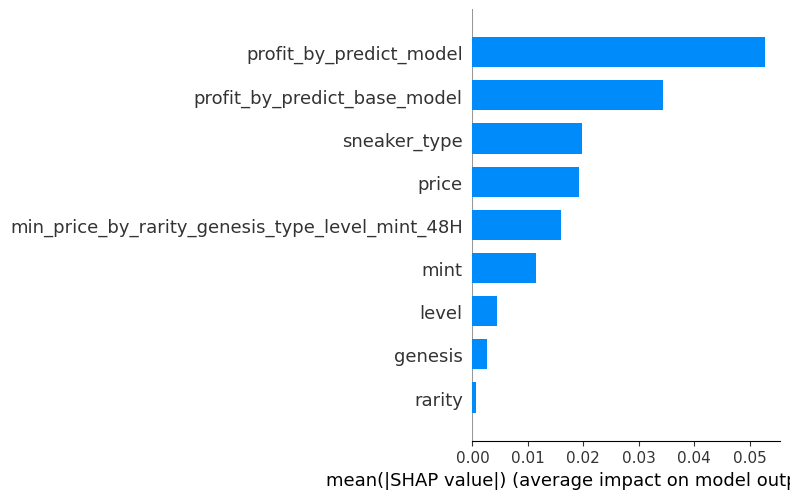

In [110]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [111]:
model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

0:	learn: 0.1270014	total: 637us	remaining: 637ms
1:	learn: 0.1258916	total: 1.39ms	remaining: 693ms
2:	learn: 0.1246855	total: 1.81ms	remaining: 603ms
3:	learn: 0.1237665	total: 2.29ms	remaining: 569ms
4:	learn: 0.1230653	total: 2.76ms	remaining: 549ms
5:	learn: 0.1222065	total: 3.22ms	remaining: 533ms
6:	learn: 0.1213504	total: 3.67ms	remaining: 520ms
7:	learn: 0.1208043	total: 4.09ms	remaining: 507ms
8:	learn: 0.1200777	total: 4.53ms	remaining: 498ms
9:	learn: 0.1195203	total: 4.94ms	remaining: 489ms
10:	learn: 0.1187614	total: 5.38ms	remaining: 484ms
11:	learn: 0.1182347	total: 5.84ms	remaining: 481ms
12:	learn: 0.1176539	total: 6.28ms	remaining: 477ms
13:	learn: 0.1170697	total: 6.71ms	remaining: 473ms
14:	learn: 0.1162796	total: 7.1ms	remaining: 466ms
15:	learn: 0.1159295	total: 7.55ms	remaining: 464ms
16:	learn: 0.1153046	total: 7.94ms	remaining: 459ms
17:	learn: 0.1147430	total: 8.28ms	remaining: 452ms
18:	learn: 0.1141896	total: 8.64ms	remaining: 446ms
19:	learn: 0.1137661	tot

In [112]:
pred = model.predict(X_test)
pred = np.round(pred, 3)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.762, 'MAE': 0.105, 'MSE': 0.016, 'RMSE': 0.127, 'MAPE': 1.051}

In [113]:
submission = pd.DataFrame()
submission['profit'] = test_data.profit.copy().reset_index(drop=True)
submission['pred'] = pred

In [114]:
submission.profit.sum()

2.1864999999999997

In [115]:
submission

,profit,pred
0,0.0215,0.147
1,0.1700,0.317
2,0.3200,0.522
3,0.4500,0.591
4,0.1015,0.058
5,0.0590,0.031
6,0.1255,0.105
7,0.0615,0.093
8,0.8775,0.672


In [116]:
submission[submission['pred'] > 0.05].profit.sum()

2.1274999999999995

In [117]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.76, 'MAE': 0.104, 'MSE': 0.016, 'RMSE': 0.127, 'MAPE': 1.058}

## Fit full Model

In [118]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_profit_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


0:	learn: 0.1290798	total: 624us	remaining: 624ms
1:	learn: 0.1280714	total: 1.2ms	remaining: 600ms
2:	learn: 0.1266302	total: 1.73ms	remaining: 575ms
3:	learn: 0.1258543	total: 2.13ms	remaining: 531ms
4:	learn: 0.1251237	total: 2.58ms	remaining: 514ms
5:	learn: 0.1243074	total: 2.99ms	remaining: 496ms
6:	learn: 0.1235751	total: 3.39ms	remaining: 481ms
7:	learn: 0.1225936	total: 3.8ms	remaining: 471ms
8:	learn: 0.1215619	total: 4.2ms	remaining: 462ms
9:	learn: 0.1209150	total: 4.61ms	remaining: 457ms
10:	learn: 0.1200645	total: 4.99ms	remaining: 449ms
11:	learn: 0.1193907	total: 5.43ms	remaining: 447ms
12:	learn: 0.1187430	total: 5.87ms	remaining: 446ms
13:	learn: 0.1181958	total: 6.29ms	remaining: 443ms
14:	learn: 0.1175001	total: 6.7ms	remaining: 440ms
15:	learn: 0.1170714	total: 7.09ms	remaining: 436ms
16:	learn: 0.1166163	total: 7.49ms	remaining: 433ms
17:	learn: 0.1161145	total: 7.85ms	remaining: 428ms
18:	learn: 0.1156104	total: 8.28ms	remaining: 428ms
19:	learn: 0.1152643	total:

In [119]:
y

0      0.0770
1      0.0455
2      0.1740
3      0.3305
4      0.0685
        ...  
243    0.1015
244    0.0590
245    0.1255
246    0.0615
247    0.8775
Name: target, Length: 248, dtype: float64

### Test

In [120]:
i=102

In [121]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sneaker_dict

{'timestamp': 1663019290,
 'mrk_id': 28412,
 'token_id': 47960,
 'event': 'buy',
 'wallet_from': '0xf5f1c1160efa7c9a2b9ad0724d2bc13592636244',
 'wallet_to': '0x3273af210822c44afd7254510e612e4dbb1040a7',
 'price': 1.0,
 'item_type': 'sneakers',
 'rarity': 'common',
 'sneaker_type': 'hiker',
 'level': 0,
 'base_performance': 7.8,
 'base_fortune': 4.4,
 'base_joy': 9.0,
 'base_durability': 5.5,
 'performance': 7.8,
 'fortune': 4.4,
 'joy': 9.0,
 'durability': 5.5,
 'mint': 0,
 'parent1': 17278.0,
 'parent2': nan,
 'genesis': True,
 'parent1_sneaker_type': nan,
 'parent2_sneaker_type': nan,
 'price_bnb': 293.04159362,
 'price_azy': 0.0893487,
 'price_amt': 0.55756515,
 'wallet_from_buy_count': 0.0,
 'wallet_from_all_count': 1.0,
 'token_all_activity_3H': 1,
 'token_sell_activity_6H': 1,
 'buy_count_12H': 227,
 'buy_count_24H': 308,
 'buy_count_48H': 540.0,
 'sell_count_12H': 453.0,
 'sell_count_24H': 669,
 'sell_count_48H': 1226.0,
 'cancel_count_12H': 304.0,
 'cancel_count_24H': 437,
 'ca

In [122]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [123]:
pd.Series(sneaker_dict)[model.feature_names_]

rarity                                             common
sneaker_type                                        hiker
genesis                                              True
level                                                   0
mint                                                    0
min_price_by_rarity_genesis_type_level_mint_48H      0.75
price                                                 1.0
profit_by_predict_model                             0.019
profit_by_predict_base_model                        -0.06
dtype: object

In [124]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_profit_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.099

In [125]:
data.iloc[i]['profit']

0.13050000000000006

iteritems is deprecated and will be removed in a future version. Use .items instead.


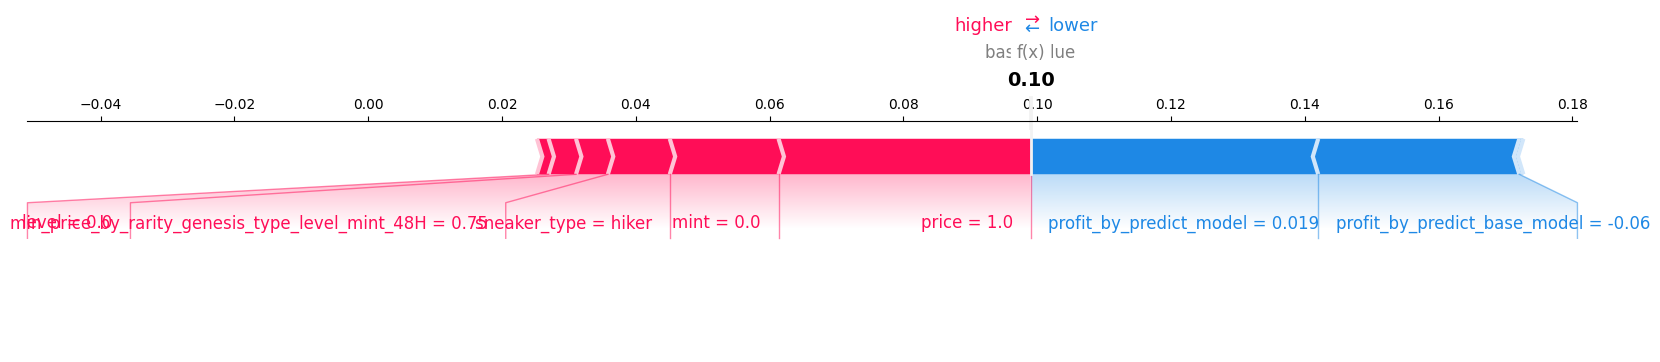

In [126]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)